<font size="6">*Predictive Modeling of Heart Disease using 11 Predictors*<font size="6">

***Introduction-***
Cardiovascular diseases causes 31% of mortality rate globally, with heart attacks as one of the leading cause of premature deaths. For individuals associated with such life threatening diseases, early detection becomes vital for improving quality of life, reducing medical expense and providing better treatment options. 

***Predictive Question-***
Can age, resting blood pressure, maximum heart rate, and cholesterol levels accurately predict whether an individual has heart failure or not?
    
Early detection could improve effectiveness of treatment, thus lowering mortality and bettering global health. 

The data set we are using is called  “Heart Failure Prediction”(https://www.kaggle.com/fedesoriano/heart-failure-prediction ) from Kaggle which incorporates demographic, clinical, and laboratory data. Features like Age, Sex, ChestPain type, restingBP, Cholesterol, Maximum heart rate etc (mentioned in the link) will be explored. 

In [15]:
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)
options(repr.matrix.mas.rows=5)

### <font size="6">Preliminary Exploratory Data Analysis<font size="6">
    
**Data Retrieval/wrangling and cleaning:** We used the URL from kaggle to read our data into R and and convert into a tidy format. Fasting blood sugar is excluded from our data table because the values in that column are displayed as 0 in the dataset provided. 


In [16]:
url<-"https://raw.githubusercontent.com/Muskandavee/PROPOSAL-/main/heart.csv?token=GHSAT0AAAAAACIL7C5ONUF7EQO6NRJV2VSKZJ4MAEQ"

In [17]:
download.file(url, "data/heart.csv")
heart_disease_data<-read_csv("data/heart.csv")|>
mutate(HeartDisease=as_factor(HeartDisease))|>
rename(ST_depression=Oldpeak)|>
mutate(HeartDisease=ifelse(HeartDisease==1, "Yes", "No"))|>
select(-FastingBS)

heart_disease_slice<-heart_disease_data|>
slice(1:5)
heart_disease_slice

Rows: 918 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope
dbl (7): Age, RestingBP, Cholesterol, FastingBS, MaxHR, Oldpeak, HeartDisease

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,Sex,ChestPainType,RestingBP,Cholesterol,RestingECG,MaxHR,ExerciseAngina,ST_depression,ST_Slope,HeartDisease
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>
40,M,ATA,140,289,Normal,172,N,0.0,Up,No
49,F,NAP,160,180,Normal,156,N,1.0,Flat,Yes
37,M,ATA,130,283,ST,98,N,0.0,Up,No
48,F,ASY,138,214,Normal,108,Y,1.5,Flat,Yes
54,M,NAP,150,195,Normal,122,N,0.0,Up,No


<font size="4">**Splitting data into training and testing set:**<font size="4">

In [18]:
set.seed(1234)
heart_disease_split <- initial_split(heart_disease_data, prop = 0.75, strata = HeartDisease)
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split)

heart_disease_slice_train<-heart_disease_train |>
slice(1:5)
heart_disease_slice_train

Age,Sex,ChestPainType,RestingBP,Cholesterol,RestingECG,MaxHR,ExerciseAngina,ST_depression,ST_Slope,HeartDisease
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>
37,M,ATA,130,283,ST,98,N,0,Up,No
39,M,NAP,120,339,Normal,170,N,0,Up,No
54,M,ATA,110,208,Normal,142,N,0,Up,No
48,F,ATA,120,284,Normal,120,N,0,Up,No
42,F,NAP,115,211,ST,137,N,0,Up,No


<font size="4"> **Summary table:**<font size="4"> 
    
This summary table shows the mean values for all numeric columns and the number of observations under each column. There is no missing data in this data set other than the 0 fasting blood sugar level mentioned above. 

In [20]:
Number_of_observations<- colSums(!is.na(heart_disease_train))
Mean_Age<- mean(heart_disease_train$Age, na.rm=TRUE)
Mean_Restingbp <- mean(heart_disease_train$RestingBP, na.rm=TRUE)
Mean_MaxHR <- mean(heart_disease_train$MaxHR, na.rm=TRUE)
Mean_Cholesterol <- mean(heart_disease_train$Cholesterol, na.rm=TRUE)

summary_stats <- rbind(Number_of_observations,tibble(Age = Mean_Age,
Sex = NA,
ChestPainType= NA,
RestingBP =Mean_Restingbp,
Cholesterol=  Mean_Cholesterol,
RestingECG =  NA,
MaxHR = Mean_MaxHR,
ExerciseAngina=NA,
ST_Slope= NA,
HeartDisease=NA))
row.names(summary_stats) <- c("Number of observations" , "Mean")
summary_stats


num_missing_rows <- sum(!complete.cases(heart_disease_train))
cat("The number of rows with missing data is", num_missing_rows, "\n")

Warning message in rbind(deparse.level, ...):
“number of columns of result, 10, is not a multiple of vector length 11 of arg 1”
Warning message:
“Setting row names on a tibble is deprecated.”


,Age,Sex,ChestPainType,RestingBP,Cholesterol,RestingECG,MaxHR,ExerciseAngina,ST_Slope,HeartDisease
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Number of observations,688.0000,688,688,688.0000,688.0000,688,688.000,688,688,688
Mean,53.7093,NA,NA,132.4244,200.0058,NA,136.798,NA,NA,NA


The number of rows with missing data is 0 


<font size="4">**Data Analysis Approach : Methods**<font size="4">
    
We have decided to use classification in order to answer our predictive question as we are looking to find a predicted group ("yes" or "no) and not a value. Hence we will not use regression.

  **STEPS:**
    
**Picking variables-**
   ChestPainType, Age, Sex, ExerciseAngina, and ST slope show the most effect on heart disease according to our visualizations below.
    
**Scaling data-**
    Standardize the selected predictor variables. k-NN is distance-based, so scaling the variables to have a similar range is crucial in order to avoid skewed results.

**Select k Value-**
    Determine the optimal value for the k parameter (number of neighbors to consider. We plan to use an odd number since we have 4 variables.

**Visualizing classification results-**
    We plan to visualise our data using a scatter plot. The reasons we chose scatter plots are to easily identify patterns, outliers,  and know insights about the data distribution. We will be using standardised data for the same. To check the accuracy of the classifier, confusion matrix will be implemented as it provides a concise and clear evaluation of for instance accuracy of of how the model is performing. Metrics such as precision and recall in the confusion matrix, allow further assembly of the model.
Threshold Tunning and F1 score will also aid in effective prediction of the model.
    

    

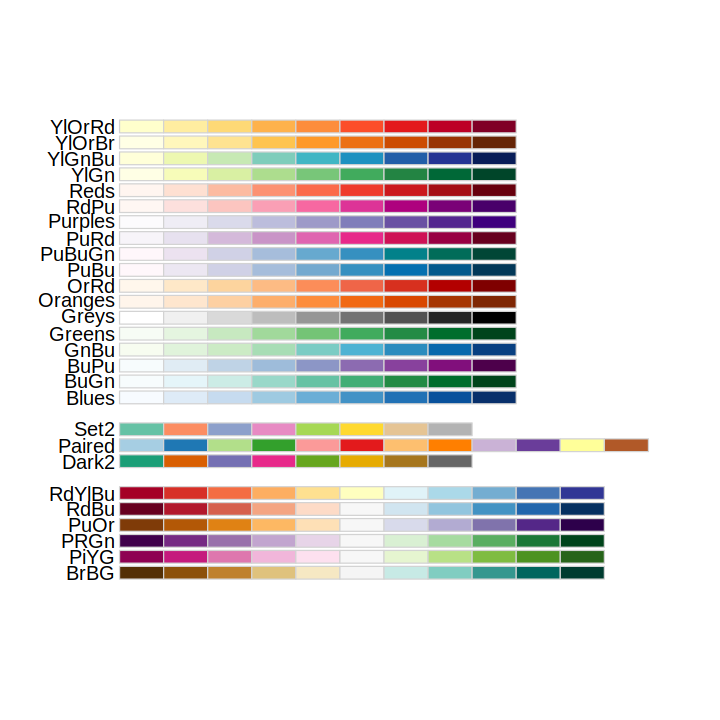

In [21]:
display.brewer.all(colorblindFriendly = TRUE)

<font size="4">**DATA VISUALISATION OF TRAINING DATA**<font size="4">
    
We explored the relationship between some of the predictors and heart disease. 


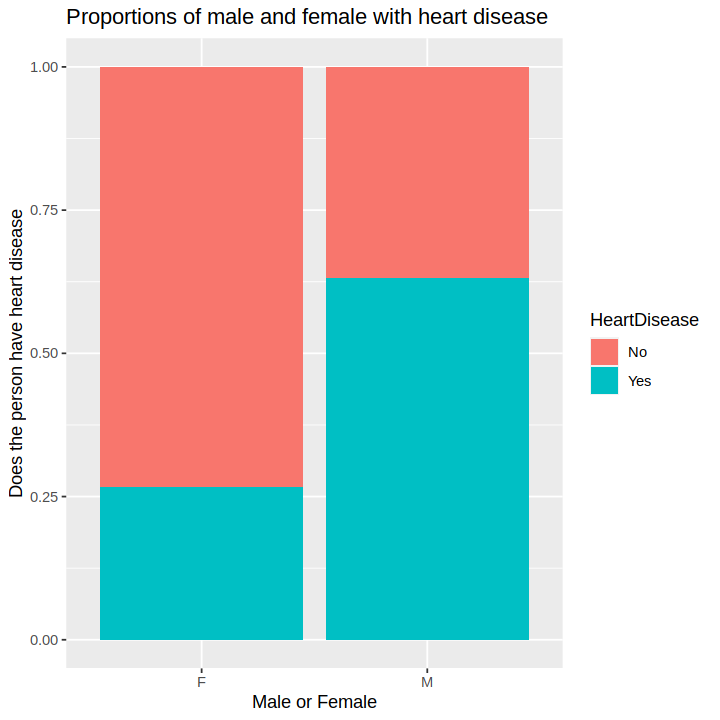

In [6]:
options(repr.plot.width = 6, repr.plot.height = 6)
sex_plot<-heart_disease_train|>
ggplot(aes(x=Sex, fill=HeartDisease))+
geom_bar(position="fill")+
xlab("Male or Female")+
ylab("Does the person have heart disease")+
labs("Heart Disease")+
ggtitle("Proportions of male and female with heart disease")+
scale_color_brewer(palette = "Set2")
sex_plot

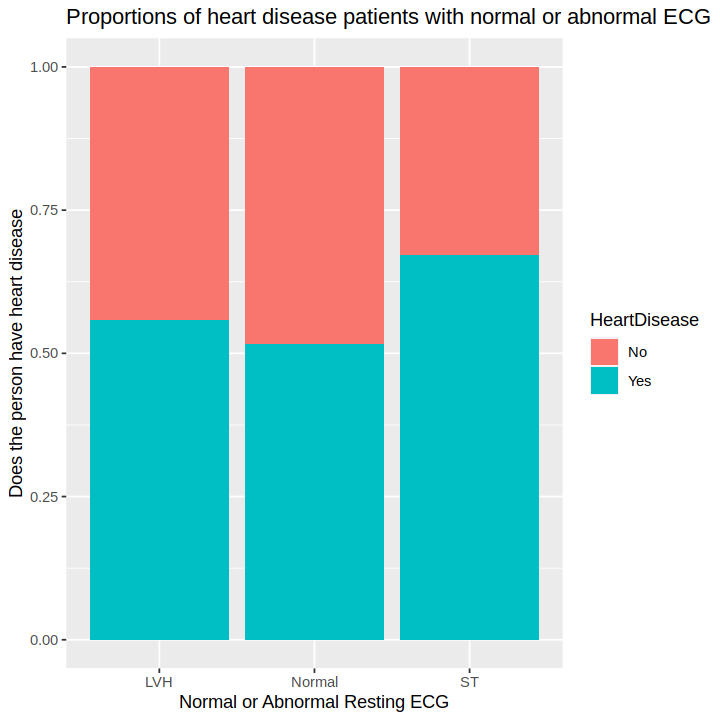

In [7]:
options(repr.plot.width = 6, repr.plot.height = 6)
Resting_ECG_plot<-heart_disease_train|>
ggplot(aes(x=RestingECG, fill=HeartDisease))+
geom_bar(position="fill")+
xlab("Normal or Abnormal Resting ECG")+
ylab("Does the person have heart disease")+
labs("Heart Disease")+
ggtitle("Proportions of heart disease patients with normal or abnormal ECG")
Resting_ECG_plot

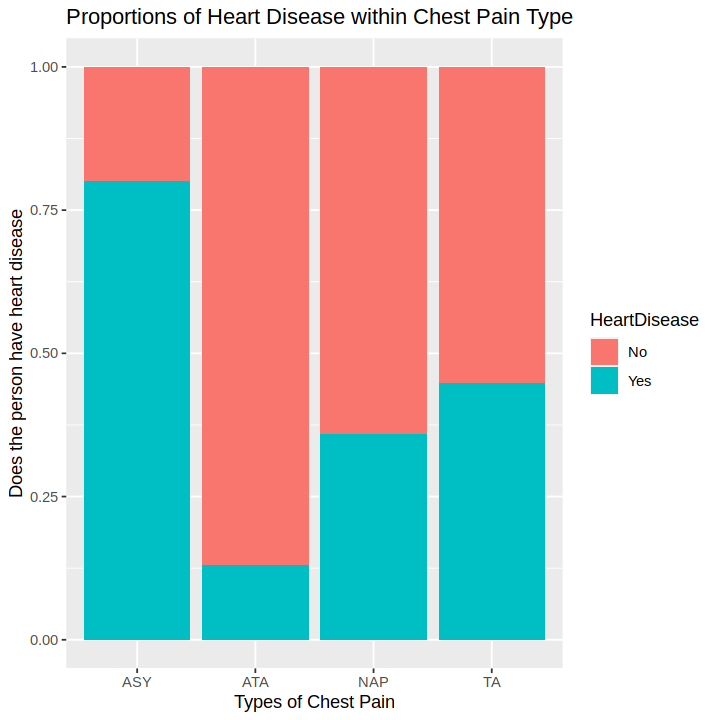

In [8]:
options(repr.plot.width = 6, repr.plot.height = 6)
Chest_pain_type_plot<-heart_disease_train|>
ggplot(aes(x=ChestPainType, fill=HeartDisease))+
geom_bar(position="fill")+
xlab("Types of Chest Pain")+
ylab("Does the person have heart disease")+
labs("Heart Disease")+
ggtitle("Proportions of Heart Disease within Chest Pain Type")
Chest_pain_type_plot

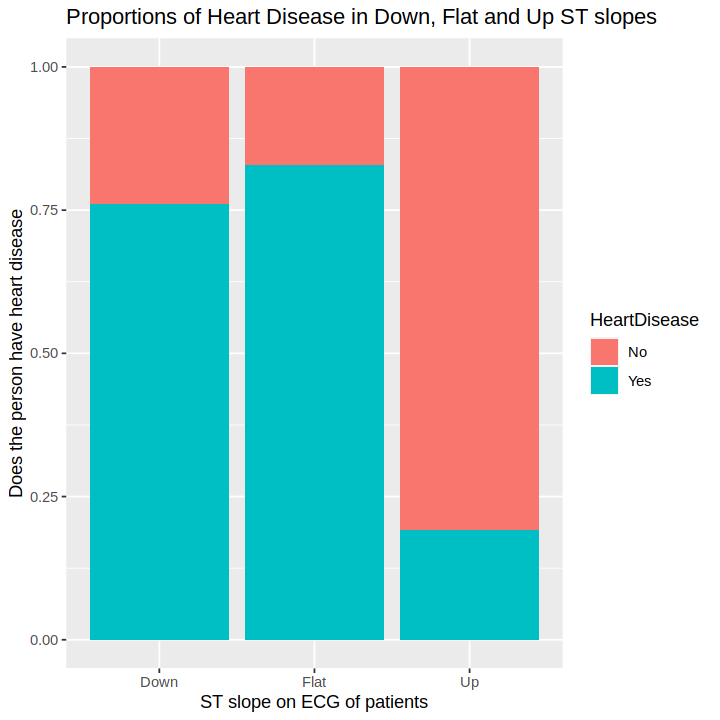

In [9]:
options(repr.plot.width = 6, repr.plot.height = 6)
ST_Slope_plot<-heart_disease_train|>
ggplot(aes(x=ST_Slope, fill=HeartDisease))+
geom_bar(position="fill")+
xlab("ST slope on ECG of patients")+
ylab("Does the person have heart disease")+
labs("Heart Disease")+
ggtitle("Proportions of Heart Disease in Down, Flat and Up ST slopes")
ST_Slope_plot

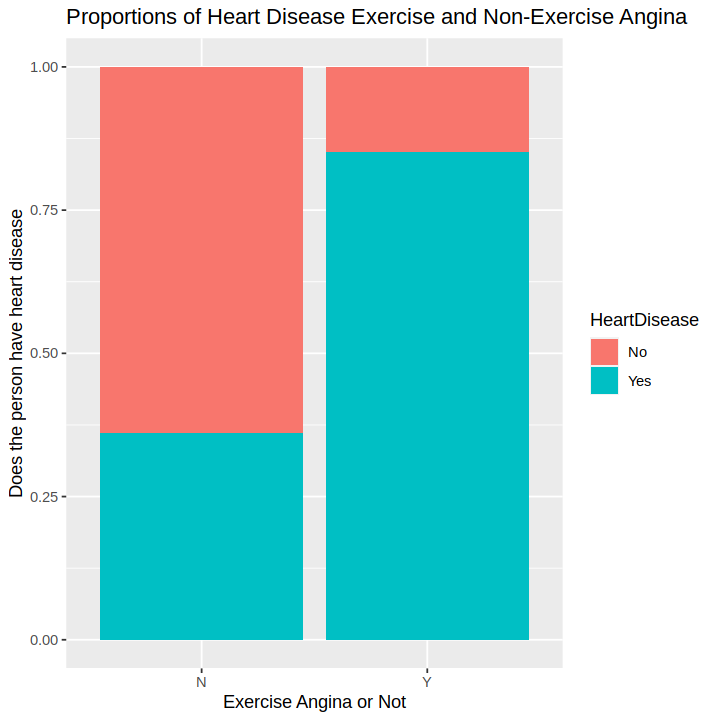

In [10]:
options(repr.plot.width = 6, repr.plot.height = 6)
Exercise_Angina_plot<-heart_disease_train|>
ggplot(aes(x=ExerciseAngina, fill=HeartDisease))+
geom_bar(position="fill")+
xlab("Exercise Angina or Not")+
ylab("Does the person have heart disease")+
labs("Heart Disease")+
ggtitle("Proportions of Heart Disease Exercise and Non-Exercise Angina")
Exercise_Angina_plot

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


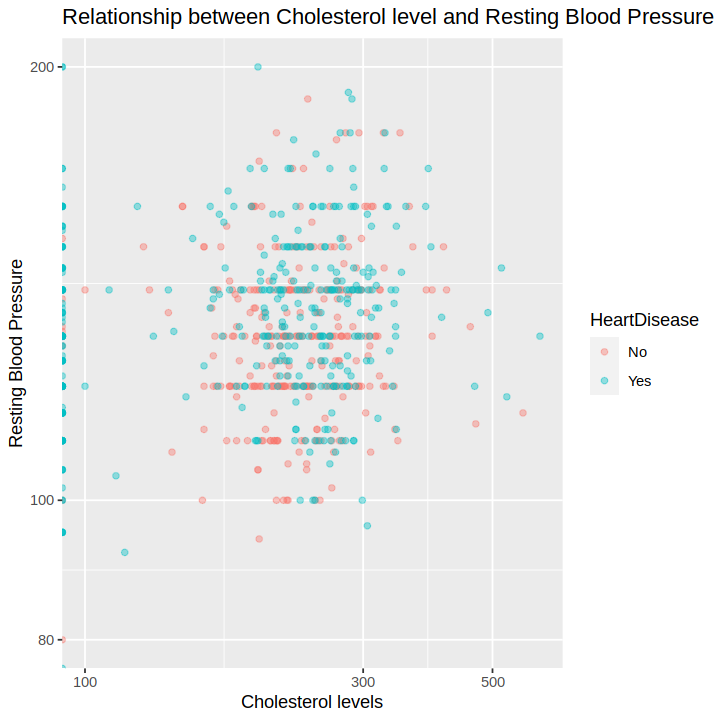

In [11]:
options(repr.plot.width = 6, repr.plot.height = 6)
Cholesterol_bloodpressure_plot<-heart_disease_train|>
ggplot(aes(x=Cholesterol, y=RestingBP))+
geom_point(aes(color=HeartDisease),alpha=0.4)+
xlab("Cholesterol levels")+
ylab("Resting Blood Pressure")+
labs("Heart Disease")+ scale_x_log10(labels = label_comma()) +
  scale_y_log10(labels = label_comma())+
ggtitle("Relationship between Cholesterol level and Resting Blood Pressure")
Cholesterol_bloodpressure_plot


Warning message:
“Transformation introduced infinite values in continuous y-axis”


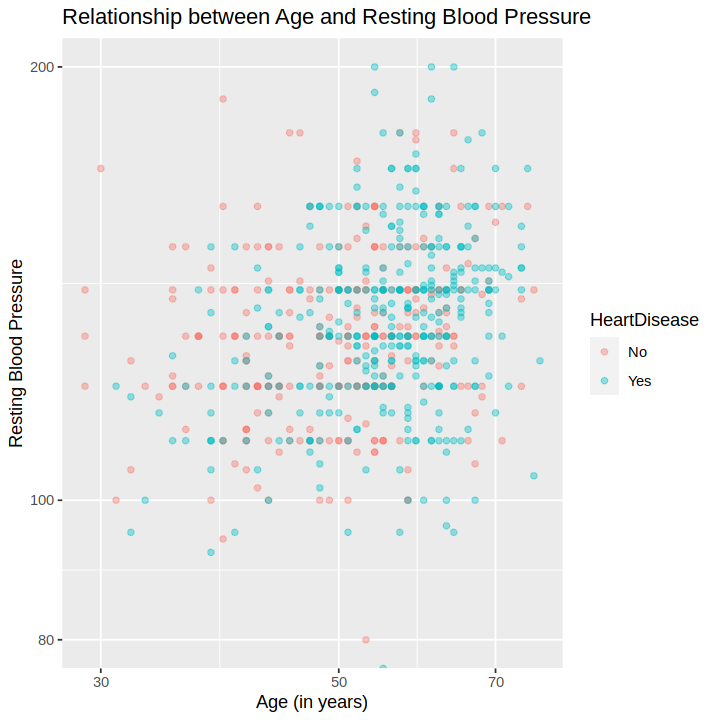

In [14]:
options(repr.plot.width = 6, repr.plot.height = 6)
Age_RestingBP_plot<-heart_disease_train|>
ggplot(aes(x=Age, y=RestingBP))+
geom_point(aes(color=HeartDisease),alpha=0.4)+
xlab("Age (in years)")+
ylab("Resting Blood Pressure")+
labs("Heart Disease")+
  scale_x_log10(labels = label_comma()) +
  scale_y_log10(labels = label_comma())+
ggtitle("Relationship between Age and Resting Blood Pressure")
Age_RestingBP_plot

Warning message:
“Transformation introduced infinite values in continuous y-axis”


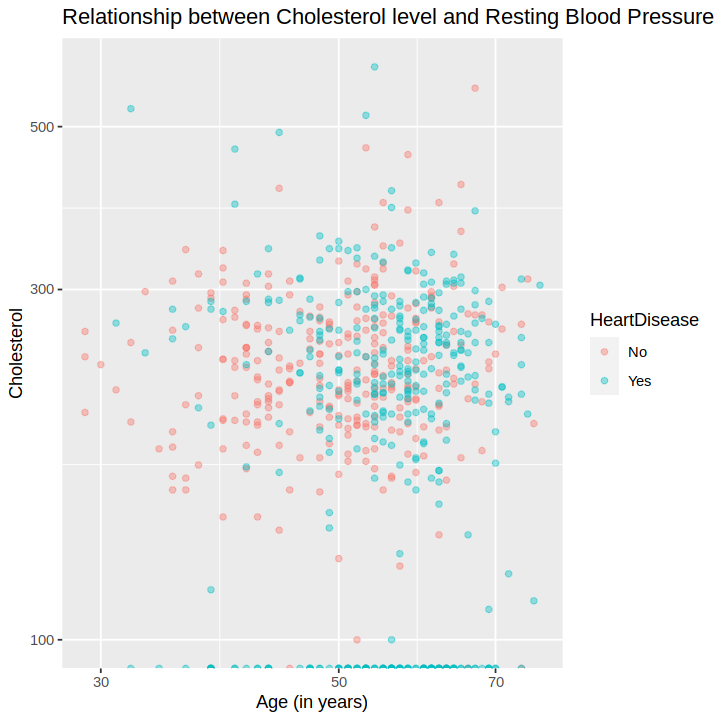

In [13]:
options(repr.plot.width = 6, repr.plot.height = 6)
Age_Cholesterol_plot<-heart_disease_train|>
ggplot(aes(x=Age, y=Cholesterol))+
geom_point(aes(color=HeartDisease),alpha=0.4)+
xlab("Age (in years)")+
ylab("Cholesterol")+
labs("Heart Disease")+
  scale_x_log10(labels = label_comma()) +
  scale_y_log10(labels = label_comma())+
ggtitle("Relationship between Cholesterol level and Resting Blood Pressure")
Age_Cholesterol_plot

<font size="5">Expected Outcomes and Significance<font size="4">
    
**Expected Findings:**
    We anticipate a predictive model that offers accurate insights into heart disease likelihood taking into consideration our predictor variables. Our code will be able to predict whether heart failure is "yes" or "no" depending on the trends observed between our predictor variables and heart disease results.

**Significance:** 
    The model's findings can significantly impact public health by enabling early detection, potentially saving lives and reducing healthcare costs.
    
**Future Questions:**
    This project may lead to further research on model refinement, additional predictors, or personalized risk assessment for heart disease to further improve accuracy of prediction.
